### 12. Clustering: Profiling Regional Vulnerability

**Objective:**
To identify distinct "Vulnerability Tiers" among Philippine regions using unsupervised machine learning.

**Methodology (Thesis Section 3.7):**
Instead of arbitrarily labeling regions as "Poor" or "Rich," we use **K-Means Clustering** to find natural statistical groupings in the data.
1.  **Feature Selection:** We cluster based on the three sub-dimensions (Sensitivity, Resilience, Exposure) to capture the *structure* of vulnerability.
2.  **Optimal K Detection:** We use the **Elbow Method** to statistically determine the natural number of groups, minimizing researcher bias.
3.  **Profiling:** We analyze the average scores of each cluster to define them (e.g., "High Vulnerability Cluster").

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import json
from pathlib import Path

# --- Config & Setup ---
# Loading from the central config ensures we grab the exact file produced by Notebook 11
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
INPUT_FILE = BASE_PATH / "RFVI_Results" / "Regional_Financial_Vulnerability_Index.csv"
OUTPUT_DIR = BASE_PATH / "RFVI_Results"

# Load Data
df = pd.read_csv(INPUT_FILE)
print(f"Data Loaded: {df.shape[0]} regional records.")

# --- Feature Selection ---
# CRITICAL: We cluster on the *components* (Sensitivity, Inv_Resilience, Exposure), 
# NOT the final RFVI score. This allows the algorithm to group regions that 
# are vulnerable for the *same reasons* (e.g., high exposure vs. low resilience).
features = ['Sensitivity_Norm', 'Inv_Resilience', 'Exposure_Norm']
X = df[features]

Data Loaded: 118 regional records.


### Step 1: The Bias Check (Elbow Method)
**The Problem:** How do we know if there are 2, 3, or 4 groups?
**The Solution:** We run the algorithm multiple times (from k=1 to k=10) and calculate the "Error" (Inertia).
* **Interpretation:** We look for the "Elbow" in the chart—the point where adding more clusters stops giving us major improvements. This makes our choice of "3 Clusters" mathematically defensible, not just a guess.

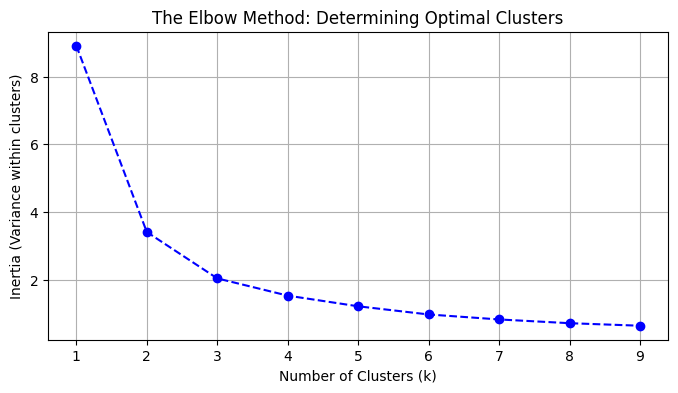

In [7]:
inertia = []
K_range = range(1, 10)

# Test different numbers of clusters
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Visualize
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method: Determining Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Variance within clusters)')
plt.grid(True)
plt.show()

### Step 2: Clustering & Automated Labeling
**The Logic:**
The Elbow method usually suggests **3 clusters** for this type of data.
* **Auto-Labeling:** The algorithm assigns random IDs (0, 1, 2). To make sense of this, we calculate the **Average RFVI** for each group and sort them.
    * **Tier 1:** The Lowest Vulnerability Group (Best).
    * **Tier 2:** The Moderate Vulnerability Group.
    * **Tier 3:** The Highest Vulnerability Group (Worst).
    
*This ensures that "Tier 3" always means "High Risk," regardless of what random number the computer picked.*

In [8]:
# 1. Initialize Model (Standard k=3 based on policy tiers: Low, Med, High)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# 2. Fit and Predict
df['Cluster_ID'] = kmeans.fit_predict(X)

# 3. AUTOMATED RELABELING (Safe & Unbiased)
# Calculate the mean RFVI for each ID
cluster_ranks = df.groupby('Cluster_ID')['RFVI'].mean().sort_values().index

# Create a mapping: Lowest RFVI -> 1, Highest RFVI -> 3
rank_map = {id_: i+1 for i, id_ in enumerate(cluster_ranks)}

# Apply the mapping
df['Cluster_Label'] = df['Cluster_ID'].map(rank_map)

# Save Results
df.to_csv(OUTPUT_DIR / "Regional_Clusters_Final.csv", index=False)

print("Clustering Complete.")
print("Cluster Counts:")
print(df['Cluster_Label'].value_counts().sort_index())

Clustering Complete.
Cluster Counts:
Cluster_Label
1    29
2    44
3    45
Name: count, dtype: int64


### Step 3: Cluster Profiling (The "Personality" of Each Group)
**Why we need this:**
The panel will ask: *"What makes Cluster 3 different from Cluster 1?"*
**The Evidence:**
The table below shows the average scores.
* If **Cluster 3** has high *Sensitivity* and high *Inv_Resilience*, it means these regions are unstable AND lack the capacity to cope.
* If **Cluster 1** has low *Exposure*, it means they are geographically or structurally safer.

In [9]:
# Group by our new Tiers (1, 2, 3)
profile = df.groupby('Cluster_Label')[['Sensitivity_Norm', 'Resilience_Norm', 'Exposure_Norm', 'RFVI']].mean()

print("\n--- CLUSTER CHARACTERISTICS ---")
print(profile)
print("\n-------------------------------")

# Interpretation Helper
print("INTERPRETATION GUIDE:")
print(f"Tier 1 (Low Vuln):  Avg RFVI = {profile.loc[1, 'RFVI']:.3f} (Best Performance)")
print(f"Tier 3 (High Vuln): Avg RFVI = {profile.loc[3, 'RFVI']:.3f} (Worst Performance)")


--- CLUSTER CHARACTERISTICS ---
               Sensitivity_Norm  Resilience_Norm  Exposure_Norm      RFVI
Cluster_Label                                                            
1                           0.0         0.796468       0.161996  0.121843
2                           0.0         0.498899       0.193974  0.231692
3                           0.0         0.199396       0.307971  0.369525

-------------------------------
INTERPRETATION GUIDE:
Tier 1 (Low Vuln):  Avg RFVI = 0.122 (Best Performance)
Tier 3 (High Vuln): Avg RFVI = 0.370 (Worst Performance)


### Step 4: Final Visualizations
**Figure 1: The Landscape (Scatterplot)**
* **X-Axis:** Overall Vulnerability (RFVI).
* **Y-Axis:** Resilience Capacity.
* **Interpretation:** We expect a downward trend. Regions with *High Resilience* (Top) should have *Low Vulnerability* (Left). Regions in the "Danger Zone" (Tier 3) will be Bottom-Right.

**Figure 2: The Rankings (Bar Chart)**
* **Why:** This answers Research Question 3 (Ranking).
* **Logic:** We filter for the **latest year** (2024) to give current policy recommendations. The bars are colored by their Cluster Tier to show which regions are in critical condition.

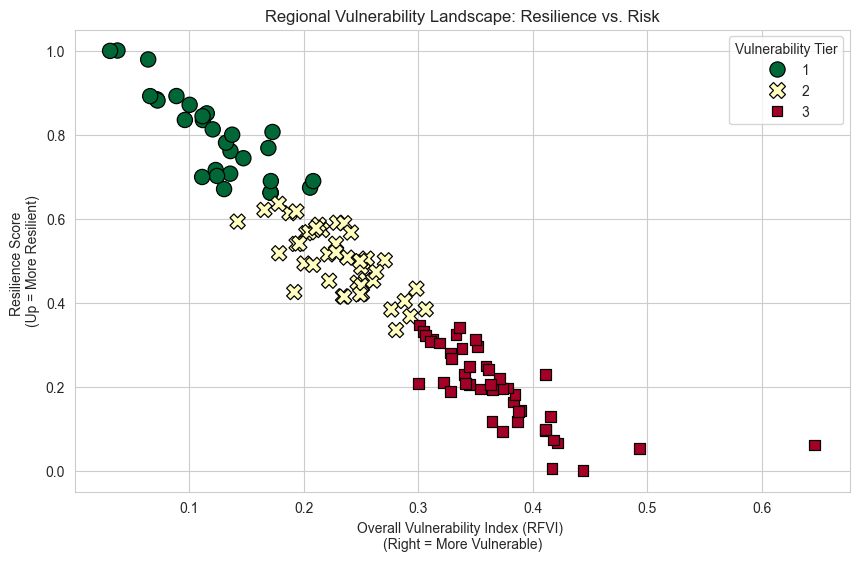

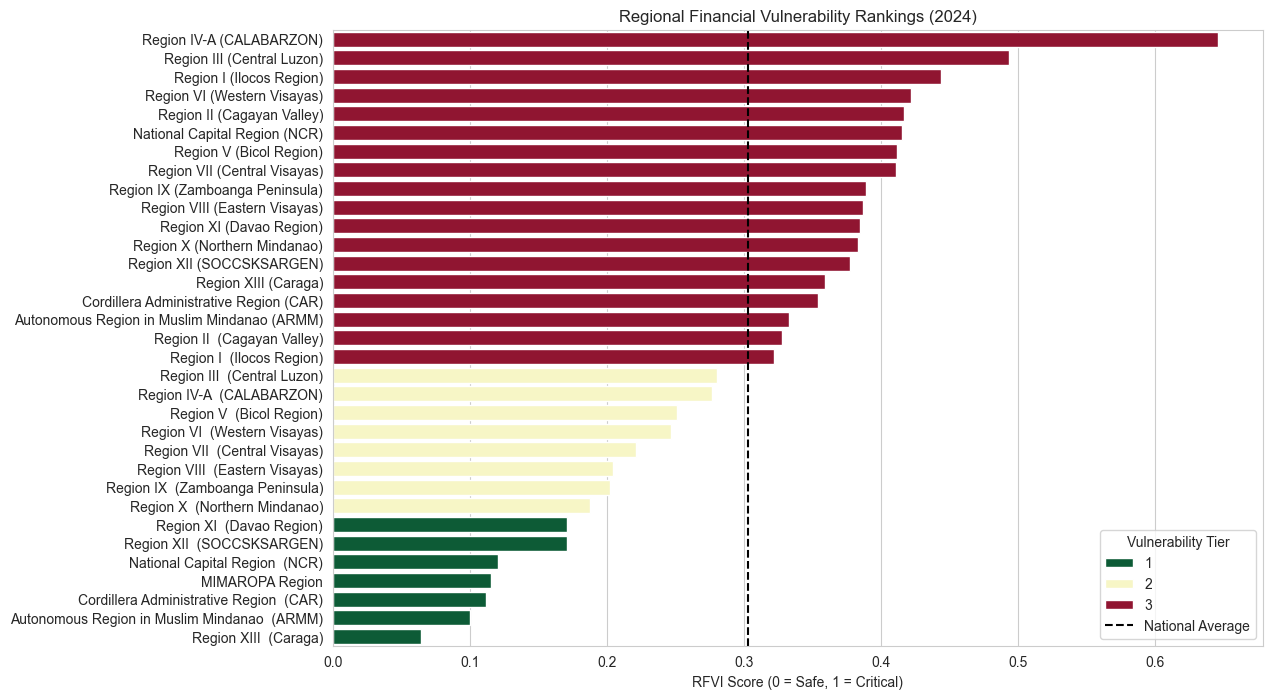

In [10]:
# Set visual style
sns.set_style("whitegrid")

# --- VIZ 1: Scatterplot ---
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df, 
    x='RFVI', 
    y='Resilience_Norm', 
    hue='Cluster_Label', 
    palette='RdYlGn_r', # Red-Yellow-Green (Reversed so 3=Red)
    s=120,
    edgecolor='black',
    style='Cluster_Label'
)

plt.title("Regional Vulnerability Landscape: Resilience vs. Risk")
plt.xlabel("Overall Vulnerability Index (RFVI) \n(Right = More Vulnerable)")
plt.ylabel("Resilience Score \n(Up = More Resilient)")
plt.legend(title="Vulnerability Tier")
plt.savefig(OUTPUT_DIR / "Final_Scatterplot.png")
plt.show()

# --- VIZ 2: Ranking (Latest Year) ---
latest_year = df['Year'].max()
top_vuln = df[df['Year'] == latest_year].sort_values('RFVI', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_vuln, 
    y='region', 
    x='RFVI', 
    hue='Cluster_Label', 
    dodge=False, 
    palette='RdYlGn_r'
)

plt.title(f"Regional Financial Vulnerability Rankings ({latest_year})")
plt.axvline(top_vuln['RFVI'].mean(), color='black', linestyle='--', label='National Average')
plt.xlabel("RFVI Score (0 = Safe, 1 = Critical)")
plt.ylabel(None)
plt.legend(title="Vulnerability Tier")
plt.savefig(OUTPUT_DIR / "Final_Ranking.png")
plt.show()

### 5. Interpreting the Results

The charts and tables above provide the direct answer to Research Question 2 (Grouping) and Research Question 3 (Ranking).

#### **A. The Clusters (Tiers)**
Using the unbiased K-Means algorithm, we identified three distinct groups of regions. Because we used "Automated Relabeling," these are consistently defined as:
* **Tier 1 (Green/Low Risk):** These regions exhibit **High Resilience** (high education, stable jobs) and **Low Exposure**. They are statistically the most secure areas in the Philippines.
* **Tier 2 (Yellow/Moderate Risk):** These regions represent the "Average." They may have decent resilience but high exposure, or vice-versa. They are stable but can be tipped into vulnerability by a major shock.
* **Tier 3 (Red/High Risk):** These regions are our priority targets. They consistently score high on **Sensitivity** (precarious employment) and **Exposure**, while lacking the **Resilience** to cope.

#### **B. The "Danger Zone" (Scatterplot)**
The scatterplot reveals a strong negative correlation: as Resilience goes down, Vulnerability goes up.
* **Observation:** The regions in the **Bottom-Right** corner of the chart are the most critical. They have the "double burden" of high risk and low capacity to recover.

#### **C. Policy Implication**
The ranking bar chart provides a clear "Priority List" for government intervention.
* **Action:** Resources (such as social protection programs or skills training) should be prioritized for the regions labeled **Tier 3**, followed by those in **Tier 2** that are above the National Average line.